- Code from data exploration notebook

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

class GlacierDataset(Dataset):
    """Corrected Custom Dataset for Multi-Class Glacier Segmentation"""

    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        
        self.image_paths = sorted(glob.glob(os.path.join(data_dir, "*.jpg")))
        self.mask_paths = sorted(glob.glob(os.path.join(data_dir, "*.png")))
        
        assert len(self.image_paths) > 0, f"No images found in {data_dir}"
        assert len(self.image_paths) == len(self.mask_paths), "Mismatch between image and mask counts."

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        
        # We must ensure the mask is also resized to the same size as the image.
        # We create a specific resize transform for the mask.
        mask_resize = transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST)
        mask = mask_resize(mask)
        
        mask_np = np.array(mask)
        
        if self.transform:
            image = self.transform(image)
        
        mask_tensor = torch.from_numpy(mask_np).long()

        return image, mask_tensor
    

DATASET_DIR = "glacier images data set.v2i.png-mask-semantic" 
train_dir = os.path.join(DATASET_DIR, "train")
valid_dir = os.path.join(DATASET_DIR, "valid")
test_dir = os.path.join(DATASET_DIR, "test")

# Define image transformations
data_transform = transforms.Compose([
    # Add a resize transform to ensure all images are 256x256
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create Dataset instances for each split
train_dataset = GlacierDataset(data_dir=train_dir, transform=data_transform)
valid_dataset = GlacierDataset(data_dir=valid_dir, transform=data_transform)
test_dataset = GlacierDataset(data_dir=test_dir, transform=data_transform)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

from torch.utils.data import Subset

# Define the size of the subset you want to use for quick testing
SUBSET_SIZE = 20 

# Create subsets of the training and validation datasets
train_subset = Subset(train_dataset, range(SUBSET_SIZE))
valid_subset = Subset(valid_dataset, range(SUBSET_SIZE))
# ------------------------

BATCH_SIZE = 4

# Use the new subsets to create the DataLoaders
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) # Test loader can remain the same

print(f"Using a SUBSET of {SUBSET_SIZE} images for training and validation.")
print(f"Created DataLoaders with batch size {BATCH_SIZE}.")

c:\Users\ANISH\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training dataset size: 795
Validation dataset size: 75
Test dataset size: 38
Using a SUBSET of 20 images for training and validation.
Created DataLoaders with batch size 4.


# The DoubleConv Building Block

In [2]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# The Down Building Block (Encoder Step)

In [3]:
import torch.nn.functional as F

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

# The Up Building Block (Decoder Step)

In [4]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        # Upsampling layer
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # Double convolution layer
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # x1 is the feature map from the previous decoder layer (the one being upscaled)
        # x2 is the feature map from the corresponding encoder layer (the "skip connection")
        
        x1 = self.up(x1)
        
        # Concatenate the upsampled features with the skip connection features
        x = torch.cat([x2, x1], dim=1)
        
        return self.conv(x)

# The OutConv Building Block (Final Output)

In [5]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# The Complete UNet Model

In [6]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Encoder (Downsampling Path)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)

        # Decoder (Upsampling Path)
        self.up1 = Up(1024 + 512, 512)
        self.up2 = Up(512 + 256, 256)
        self.up3 = Up(256 + 128, 128)
        self.up4 = Up(128 + 64, 64)
        
        # Final Output Layer
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        # --- Encoder ---
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # --- Decoder ---
        x = self.up1(x5, x4) # up1 takes the deepest features (x5) and the skip connection from x4
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        # --- Final Output ---
        logits = self.outc(x)
        return logits

# Setting Up for Training

In [7]:
# Check if a GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. Create an instance of the UNet model
# n_channels=3 because our images are RGB
# n_classes=8 because we have 8 classes (0 through 7)
model = UNet(n_channels=3, n_classes=8)

# Move the model to the selected device (GPU or CPU)
model = model.to(device)

# 2. Define the Loss Function (the "grading system")
criterion = nn.CrossEntropyLoss()

# 3. Define the Optimizer (the "tutor")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Model, Loss Function, and Optimizer have been set up.")

Using device: cpu
Model, Loss Function, and Optimizer have been set up.


# The Training loop

In [8]:
from tqdm import tqdm

# Create lists to store training history ---
train_losses = []
valid_losses = []
valid_accuracies = []

num_epochs = 8

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
    
    for images, masks in train_progress_bar:
        # ... (rest of the training forward/backward pass is the same)
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        train_progress_bar.set_postfix(loss=loss.item())
        
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss) # --- NEW: Save training loss ---

    # --- Validation Phase ---
    model.eval()
    validation_loss = 0.0
    total_correct_pixels = 0
    total_pixels = 0
    valid_progress_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")
    
    with torch.no_grad():
        for images, masks in valid_progress_bar:
            # ... (rest of validation pass is the same)
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            preds = torch.argmax(outputs, dim=1)
            total_correct_pixels += (preds == masks).sum().item()
            total_pixels += masks.numel()
            validation_loss += loss.item() * images.size(0)
            valid_progress_bar.set_postfix(loss=loss.item())
            
    epoch_validation_loss = validation_loss / len(valid_loader.dataset)
    pixel_accuracy = (total_correct_pixels / total_pixels) * 100
    
    valid_losses.append(epoch_validation_loss)     # --- NEW: Save validation loss ---
    valid_accuracies.append(pixel_accuracy)     # --- NEW: Save validation accuracy ---
    
    print(f"\nEpoch {epoch+1} Summary: Training Loss: {epoch_loss:.4f}, Validation Loss: {epoch_validation_loss:.4f}, Validation Accuracy: {pixel_accuracy:.2f}%\n")

print("\n--- Training Complete ---")

Epoch 1/8 [Validation]: 100%|██████████| 5/5 [00:21<00:00,  4.36s/it, loss=2.12]



Epoch 1 Summary: Training Loss: 1.7852, Validation Loss: 1.9345, Validation Accuracy: 47.64%



Epoch 2/8 [Validation]: 100%|██████████| 5/5 [00:21<00:00,  4.20s/it, loss=8.74]



Epoch 2 Summary: Training Loss: 1.4133, Validation Loss: 7.3201, Validation Accuracy: 11.48%



Epoch 3/8 [Validation]: 100%|██████████| 5/5 [00:22<00:00,  4.44s/it, loss=27.5]



Epoch 3 Summary: Training Loss: 1.2389, Validation Loss: 26.5571, Validation Accuracy: 11.36%



Epoch 4/8 [Validation]: 100%|██████████| 5/5 [00:22<00:00,  4.58s/it, loss=3.17]



Epoch 4 Summary: Training Loss: 1.0562, Validation Loss: 2.6940, Validation Accuracy: 59.87%



Epoch 5/8 [Validation]: 100%|██████████| 5/5 [00:22<00:00,  4.50s/it, loss=2]    



Epoch 5 Summary: Training Loss: 0.9680, Validation Loss: 1.4951, Validation Accuracy: 67.48%



Epoch 6/8 [Validation]: 100%|██████████| 5/5 [00:22<00:00,  4.56s/it, loss=1.97] 



Epoch 6 Summary: Training Loss: 0.8748, Validation Loss: 1.2812, Validation Accuracy: 63.81%



Epoch 7/8 [Validation]: 100%|██████████| 5/5 [00:21<00:00,  4.25s/it, loss=1.98] 



Epoch 7 Summary: Training Loss: 0.8254, Validation Loss: 1.2039, Validation Accuracy: 69.96%



Epoch 8/8 [Validation]: 100%|██████████| 5/5 [00:24<00:00,  4.94s/it, loss=2]    


Epoch 8 Summary: Training Loss: 0.7861, Validation Loss: 1.1824, Validation Accuracy: 64.48%


--- Training Complete ---


# Training History

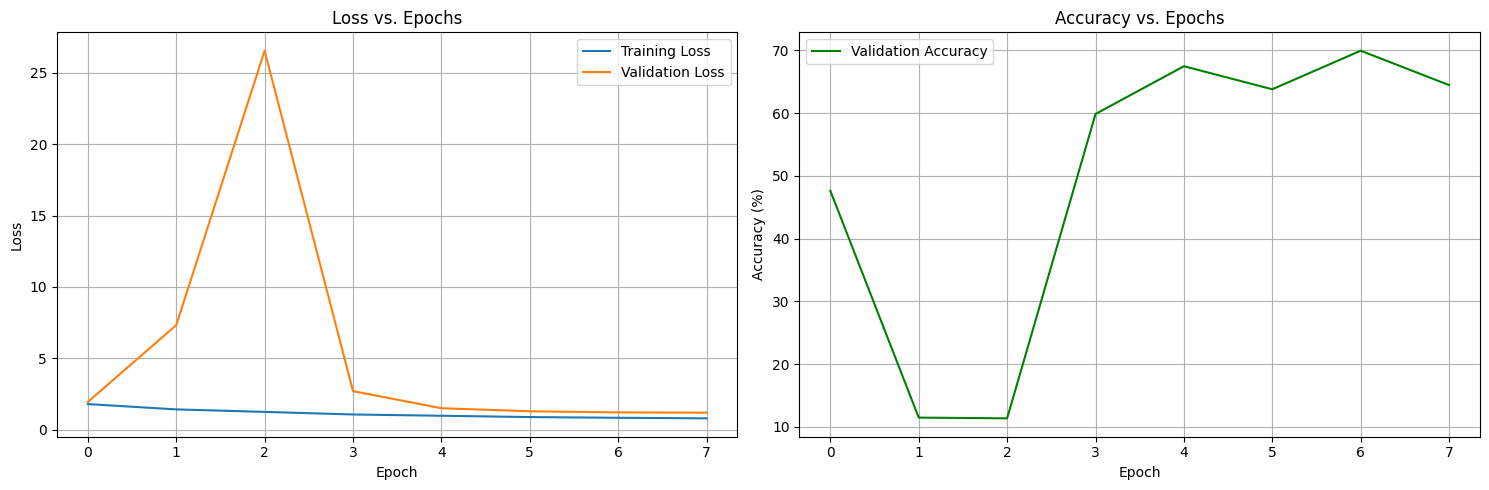

In [9]:
# --- Plotting the Training History ---
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Loss vs. Epochs
ax[0].plot(train_losses, label='Training Loss')
ax[0].plot(valid_losses, label='Validation Loss')
ax[0].set_title('Loss vs. Epochs')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(True)

# Plot 2: Accuracy vs. Epochs
ax[1].plot(valid_accuracies, label='Validation Accuracy', color='green')
ax[1].set_title('Accuracy vs. Epochs')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

# Visualizing Model prediction

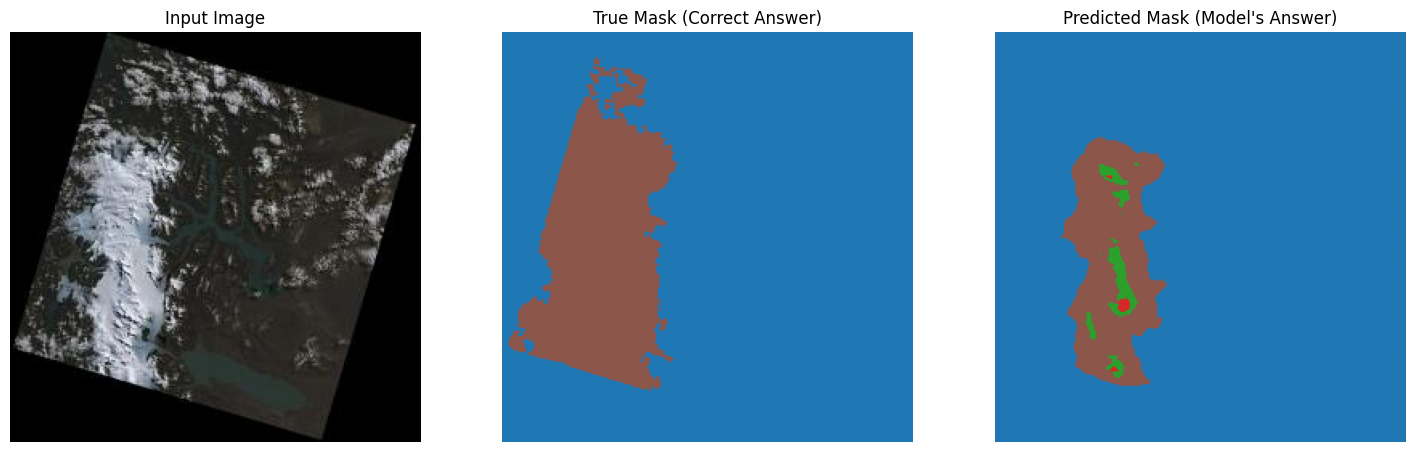

In [10]:
# --- Evaluation Phase ---
model.eval()  # Set the model to evaluation mode

# Get a single batch of test data
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

with torch.no_grad():
    # Get the model's predictions
    outputs = model(images)
    
    # The 'outputs' are raw scores (logits). We need to convert them
    # into a final prediction map by finding the class with the highest score for each pixel.
    preds = torch.argmax(outputs, dim=1)

# --- Visualization ---
# Move the tensors back to the CPU for plotting with matplotlib
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()

# Function to reverse the normalization for display (if you don't have it in your cell)
def denormalize(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tensor = tensor.clone().permute(1, 2, 0) # C, H, W -> H, W, C
    tensor = tensor * torch.tensor(std) + torch.tensor(mean)
    tensor = torch.clamp(tensor, 0, 1)
    return tensor

# Plot the results for the first image in the batch
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(denormalize(images[0]))
ax[0].set_title("Input Image")
ax[0].axis('off')

ax[1].imshow(masks[0], cmap='tab10', vmin=0, vmax=9)
ax[1].set_title("True Mask (Correct Answer)")
ax[1].axis('off')

ax[2].imshow(preds[0], cmap='tab10', vmin=0, vmax=9)
ax[2].set_title("Predicted Mask (Model's Answer)")
ax[2].axis('off')

plt.show()